# Probabilistic K-nearest Neighbours (PKNN)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
X, Y = make_moons(n_samples=50, random_state=314, noise=0.2)

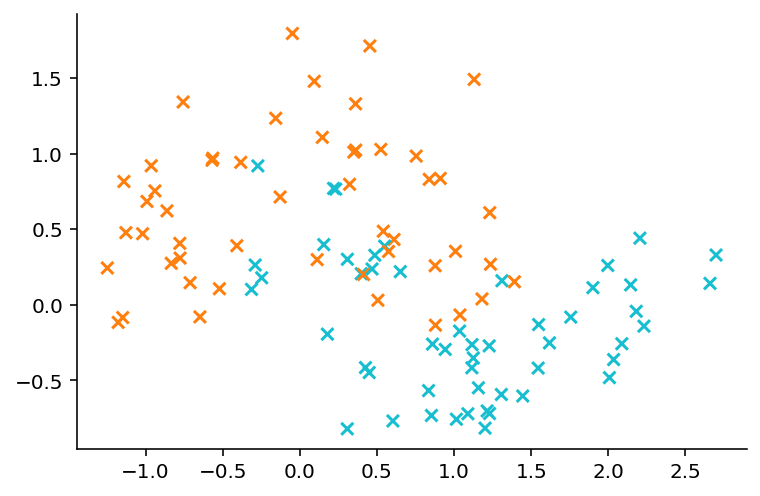

In [4]:
noise = 0.3
X, y = make_moons(101, noise=noise, random_state=314)
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")

## Plain-vanilla K-nearest neighbours

In [5]:
def knn(x, X, Y, k):
    """
    Classify an input x based on
    its k closest nearest neighbours
    
    Parameters
    ----------
    x: jnp.array(M,)
        Test observation
    X: jnp.array(N, M)
        Train features
    y: jnp.array(N,)
        Train covariates
    """
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1)
    nearest = jnp.argsort(distances)
    
    Y_pred = jnp.take(Y, nearest) * mask
    return Y_pred.sum() / k 

In [6]:
k = 3
knn_vmap = jax.vmap(knn, (1, None, None, None), out_axes=0)
knn_vmap = jax.vmap(knn_vmap, (2, None, None, None), out_axes=1)
knn_vmap_k = jax.vmap(knn_vmap, (None, None, None, 0), out_axes=0)

In [7]:
steps = 25j
steps = 0.009
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
grid = jnp.mgrid[xmin:xmax:steps, ymin:ymax:steps]
k_values = jnp.array([1, 3, 6, 12])

k_distances_grid = knn_vmap_k(grid, X, y, k_values)

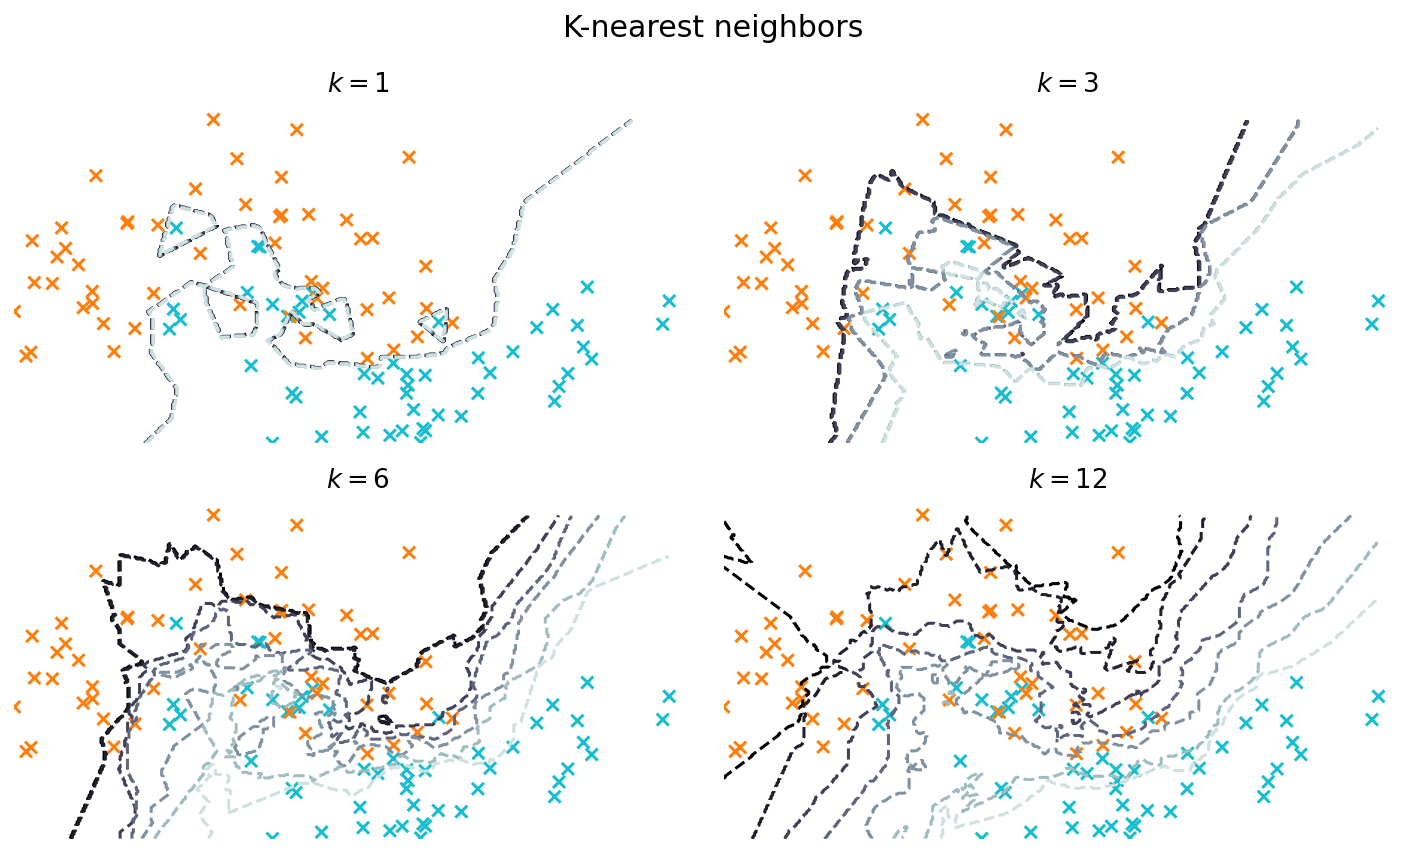

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, k, dgrid in zip(ax, k_values, k_distances_grid):    
    axi.axis("off")
    axi.contour(*grid, dgrid, cmap="bone", linestyles="--")
    axi.set_title(f"$k={k}$", fontsize=13)
    axi.scatter(*X.T, c=colors, marker="x")
plt.suptitle("K-nearest neighbors", fontsize=15)
plt.tight_layout()

## Probabilistic KNN

$$
p(y_i \vert {\bf x}, \beta, k) = \frac{\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = y_i)\right)}{\sum_{q=1}^Q\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = q)\right)}
$$

In [168]:
def knn_term(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N)
    mask = (mask <= k) * (mask > 0)
    
    distances = jnp.linalg.norm(x - X, axis=1) ** 2
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    return jnp.exp(dist)

knn_term_vmap = jax.vmap(knn_term, (0, 0, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term, (0, None, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term_classes_vmap, (None, 0, None, None, None, None))

In [341]:
k = 6
beta = 0.1
Q = 2
noise = 0.3

X_cv, y_cv = make_moons(20, noise=noise, random_state=271)

classes = jnp.array([0, 1])
x_test = jnp.array([0, 0.5])

In [170]:
unnorm_prob = knn_term_classes_vmap(X_cv, classes, X_cv, y_cv, k, beta)

N, _ = X_cv.shape
normalisation = unnorm_prob.sum(axis=0)
unnorm_prob = unnorm_prob[y_cv, jnp.arange(N)]

likelihood = unnorm_prob / normalisation
likelihood

DeviceArray([0.5083321 , 0.51665986, 0.5083321 , 0.5083321 , 0.51665986,
             0.51665986, 0.4916679 , 0.48334005, 0.51665986, 0.5083321 ,
             0.51665986, 0.5083321 , 0.5083321 , 0.5083321 , 0.5083321 ,
             0.5083321 , 0.4916679 , 0.4916679 , 0.5083321 , 0.5       ],            dtype=float32)

In [285]:
def compute_likelihood(X, y, k, beta):
    N, _ = X.shape
    unnorm_prob = knn_term_classes_vmap(X, classes, X, y, k, beta)
    
    normalisation = unnorm_prob.sum(axis=0)
    unnorm_prob = unnorm_prob[y, jnp.arange(N)]

    likelihood = unnorm_prob / normalisation

    
    return jnp.prod(likelihood)

In [286]:
compute_likelihood(X_cv, y_cv, k, beta)

DeviceArray(1.2182519e-06, dtype=float32)

## Sampling

In [287]:
def knn_mcmc_step(key, state, X, y, eta=1):
    k, beta, count_acc = state
    
    key_beta, key_k, key_accept = jax.random.split(key, 3)
    
    delta_beta = jax.random.normal(key_beta)
    delta_k = jax.random.choice(key_k, jnp.arange(-4, 5))
    alpha = jax.random.uniform(key_accept)
    
    k_hat = jnp.clip(k + delta_k, 1, N)
    
    beta_hat = jnp.abs(beta + delta_beta * eta)
    
    L_hat = compute_likelihood(X, y, k_hat, beta_hat)
    L = compute_likelihood(X, y, k, beta)
    A = jnp.minimum(1, L_hat / L)
    k, beta, acc = jax.lax.cond(A > alpha, lambda: (k_hat, beta_hat, 1),
                                           lambda: (k, beta, 0))
    
    count_acc = count_acc + acc
    res = {
        "k": k,
        "beta": beta,
        "delta_k": delta_k
    }
    return (k, beta, count_acc), res

In [288]:
def knn_mcmc(key_init, k_init, beta_init, X, y, eta, num_steps, num_warmup):
    num_steps = num_warmup + num_steps
    keys_steps = jax.random.split(key_init, num_steps)
    
    knnmcmc_part = partial(knn_mcmc_step, X=X, y=y, eta=eta)
    init_state = (k_init, beta_init, 0)
    (_, _, n_acc), chain = jax.lax.scan(lambda s, k: knnmcmc_part(k, s), init_state, keys_steps)
    
    chain["prop_accepted"] = n_acc / num_steps
    return chain

In [289]:
num_steps = 10_000
num_warmup = 2_000
eta = 1.5
key = jax.random.PRNGKey(3141)
# key_steps, key_k, key_beta = jax.random.split(key, 3)
keys = jax.random.split(key, 3)

k_init = jnp.array([1.0, 30, 2.0])
beta_init = jnp.array([10, 0.01, 2.0])

knn_mcmc_vmap = jax.vmap(knn_mcmc, (0, 0, 0, None, None, None, None, None))
chains = knn_mcmc_vmap(keys, k_init, beta_init, X_cv, y_cv, eta, num_steps, num_warmup)

chains["prop_accepted"]

DeviceArray([0.45991665, 0.46841666, 0.46175   ], dtype=float32)

In [290]:
chains["k"][:, num_warmup:].mean(axis=1)

DeviceArray([7.0364   , 7.1029   , 6.9909997], dtype=float32)

In [291]:
chains["beta"][:, num_warmup:].mean(axis=1)

DeviceArray([4.0687647, 4.127187 , 4.013319 ], dtype=float32)

Text(0, 0.5, 'mean value')

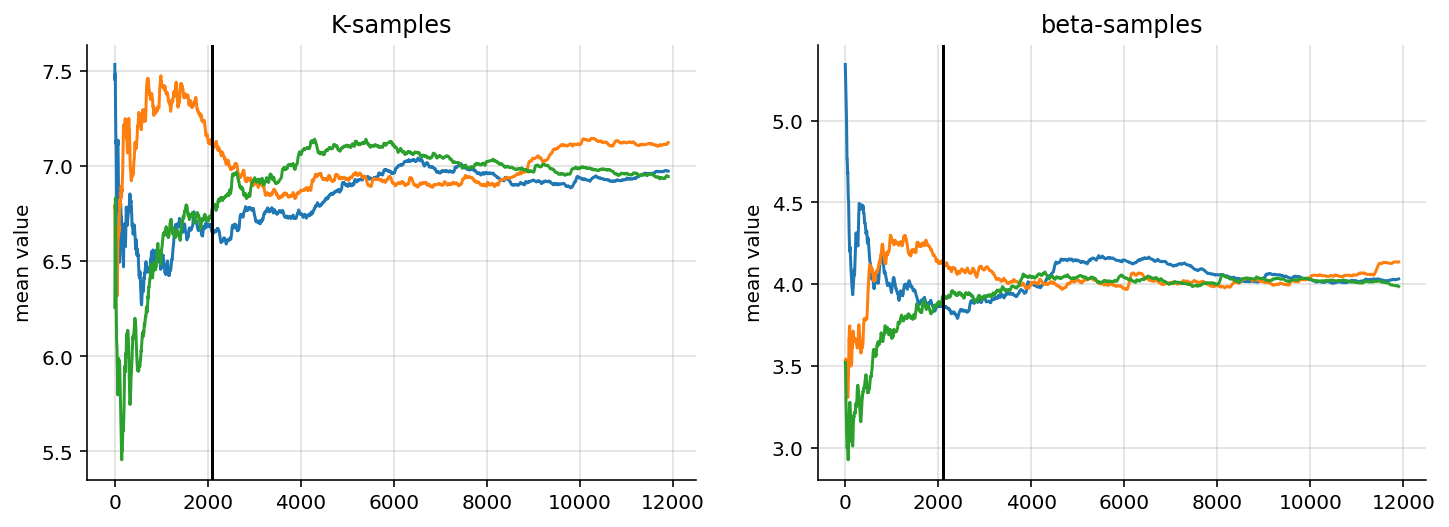

In [452]:
steps = jnp.arange(1, num_steps + num_warmup + 1)

rolling_beta = chains["beta"].cumsum(axis=1) / steps
rolling_k = chains["k"].cumsum(axis=1) / steps

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(rolling_k.T[100:])
ax[1].plot(rolling_beta.T[100:])

ax[0].set_title("K-samples")
ax[1].set_title("beta-samples")

ax[0].grid(alpha=0.4)
ax[1].grid(alpha=0.4)

ax[0].axvline(x=num_warmup + 100, c="black")
ax[1].axvline(x=num_warmup + 100, c="black")
ax[0].set_ylabel("mean value")
ax[1].set_ylabel("mean value")

### The predictive distribution

$$
    p(y_{n+1}\vert {\bf x}_{n+1}, Y, X) \approx \frac{1}{I}\sum_{i=1}^Ip(y_{n + 1}\vert Y, X, \beta^{(i)}, k^{(i)})
$$

In [534]:
def knnexp(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1) ** 2
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    return jnp.exp(dist)

knnexp_vmap = jax.vmap(knnexp, (None, 0, None, None, None, None))


def knn_prob(x, y, X, Y, k, beta):
    unnorm_prob = knnexp_vmap(x, classes, X, Y, k, beta)
    normalisation = unnorm_prob.sum()
    unnorm_prob = unnorm_prob[y]

    prob = unnorm_prob / normalisation
    return prob

In [637]:
chains_beta = chains["beta"][1][-700:]
chains_k = chains["k"][1][-700:]

In [638]:
x_test = jnp.array([-1, 1])
knnexp_vmap(x_test, classes, X_cv, y_cv, 3, 1)

DeviceArray([2.71828, 1.     ], dtype=float32, weak_type=True)

In [639]:
x_test = jnp.array([2, -1])
knnexp_vmap(x_test, classes, X_cv, y_cv, 3, 1)

DeviceArray([1.     , 2.71828], dtype=float32, weak_type=True)

In [640]:
x_test = jnp.array([-1, -1])
knn_prob(x_test, 0, X_cv, y_cv, 3, 1)

DeviceArray(0.5825699, dtype=float32)

In [641]:
x_test = jnp.array([2, -1])
knn_prob(x_test, 0, X_cv, y_cv, 2, 1)

DeviceArray(0.26894155, dtype=float32)

In [642]:
x_test = jnp.array([2, -1])
knn_prob_posterior = jax.vmap(knn_prob, (None, None, None, None, 0, 0))
probs = knn_prob_posterior(x_test, 0, X_cv, y_cv, chains_beta, chains_k)
probs.mean(axis=0)

DeviceArray(0.01367692, dtype=float32)

In [643]:
x_test = jnp.array([-0.3, -1])
knn_prob_posterior = jax.vmap(knn_prob, (None, None, None, None, 0, 0))
probs = knn_prob_posterior(x_test, 0, X_cv, y_cv, chains_beta, chains_k)
probs.mean(axis=0)

DeviceArray(0.14056659, dtype=float32)

In [644]:
# todo: Fix this!
x_test = jnp.array([-1, -1])
knn_prob_posterior = jax.vmap(knn_prob, (None, None, None, None, 0, 0))
probs = knn_prob_posterior(x_test, 0, X_cv, y_cv, chains_beta, chains_k)
probs.mean(axis=0)

DeviceArray(nan, dtype=float32)

In [630]:
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior, (1, None, None, None, None, None), out_axes=0)
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior_grid, (2, None, None, None, None, None), out_axes=1)

In [631]:
k_probs_posterior_grid = knn_prob_posterior_grid(grid, 0, X_cv, y_cv, chains_beta, chains_k)
k_probs_posterior_grid = k_probs_posterior_grid.mean(axis=-1)

In [632]:
k_probs_posterior_grid.std()

DeviceArray(0.4069302, dtype=float32)

In [633]:
x_test = jnp.array([0.5, 0.0])
probs = knn_prob_posterior(x_test, 0, X_cv, y_cv, chains_beta, chains_k)
probs.mean()

DeviceArray(0.40404597, dtype=float32)

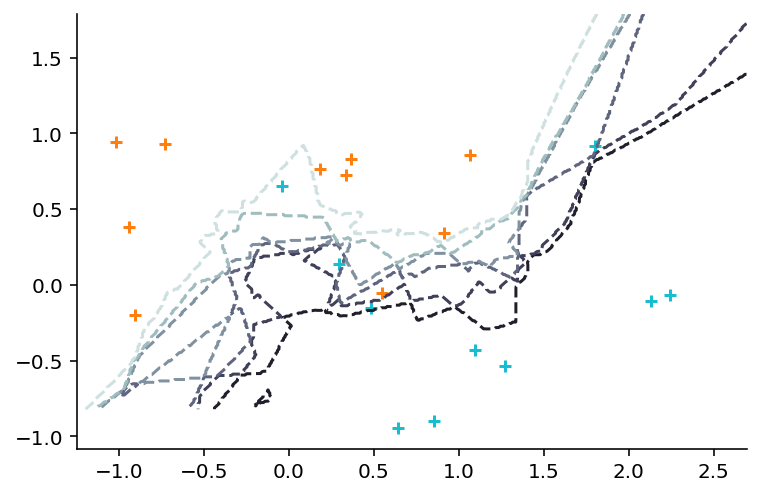

In [634]:
colors = ["tab:cyan" if yi else "tab:orange" for yi in y_cv]
plt.scatter(*X_cv.T, c=colors, marker="+")
plt.contour(*grid, k_probs_posterior_grid, cmap="bone", linestyles="--")